In [1084]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Puesto que todos los agentes comienzan en la misma posición es necesario tener un MultiGrid
from mesa.space import MultiGrid

#Importamos Random Activation ya que queremos que los agentes tomen decisiones 1 a la vez para evitar conflictos de choque
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

#Importamos random para obtener coordenadas al azar para setear nuestros dirty cells
import random

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [1085]:
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 3
    def step(self):
        
        #Obtenemos las posibles celdas a las que el agente se puede mover
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)

        #Validamos que de las posibles celdas, no haya ya un agente ahí y
        # también validamos que si haya celdas vacías
        empty_cells = [cell for cell in possible_steps if self.model.grid.is_cell_empty(cell)] 

        if (empty_cells) :
            #Si el dirty value es 1 significa que la celda está sucia, por lo que
            #seteamos el valor a 0 a través del agente
            # Y nos movemos a una nueva celda para realizar el mismo proceso
            
            current_dirty_value = self.model.get_dirty_value(self.pos[0],self.pos[1] )
            if current_dirty_value == 1:
                self.model.clean(self.pos[0],self.pos[1])
                self.model.update_cells()
                chosen_cell = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, chosen_cell)
            else:
                chosen_cell = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, chosen_cell)


In [1086]:
#En get_grid obtenemos los contenidos de nuestra celda y seteamos valores numéricos
#para después setear los colores en el grid

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)
    
    for (content, (x, y)) in model.grid.coord_iter():

        if content:
            grid[x][y] = 1   # Cleaning agent

        elif model.get_dirty_value(x, y) == 1: 
            grid[x][y] = 2  # Dirty cell (brown)
        else:
            grid[x][y] = 0  # Empty cell
    return grid


In [1087]:
class CleaningModel(Model):
    def __init__ (self, width, height, num_agents, dirty_percent = 0.9):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        #inicializamos valores, llenamos la matriz de valores en 0 para dirty
        self.dirty = np.zeros((width, height))

        #calculamos el valor de celdas sucias a través del largo y ancho multiplicado
        #por el porcentaje de celdas sucias que queremos
        self.dirty_cells = int (width*height* dirty_percent)

        #añadimos una id única a los agentes
        id = 0
        
        for i in range(1, (num_agents + 1)):
                cleaner = CleaningAgent(id, self)
                self.grid.place_agent(cleaner, (1, 1))
                self.schedule.add(cleaner)
                id = id + 1

        #Elegimos coordenadas al azar y validamos que no haya un agente ahí
        #en esa coordenada seteamos el valor de dirty a 1 
        for i in range(1, self.dirty_cells+1):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                self.dirty[x][y] = 1

    def get_dirty_value(self,x,y):
        return self.dirty[x][y] 

    def clean(self, x,y ):
        self.dirty[x][y] = 0

    #Cada vez que seteamos el valor a 0 de dirty desde el agente también
    #reducimos el valor de dirty cells para hacer el calculo de procentaje

    def update_cells(self):
        self.dirty_cells = self.dirty_cells -1 

    def get_dirty_cells(self):
        return self.dirty_cells
    
    def step(self):
        if self.get_dirty_cells() == 0:
            self.running = False
        else:
            self.datacollector.collect(self)
            self.schedule.step()            


In [1088]:
WIDTH = 100
HEIGHT = 100
DIRTY_PERCENTAGE = 0.9  
NUM_AGENTS = 5
# Definimos el número máximo de steps a correr
MAX_STEPS = 10000

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = CleaningModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_PERCENTAGE)

for i in range(MAX_STEPS):
    model.step()

#Hacemos calculo de celdas sucias al dividirlo entre el el tamaño de la matriz y
#multiplicamos por 100

print("celdas sucias: ",model.get_dirty_cells())

print("Porcentaje de celdas sucias: {:.2f}%".format(model.get_dirty_cells() / (WIDTH * HEIGHT) * 100))

# Imprimimos el tiempo que le tomó correr al modelo.

print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

celdas sucias:  6726
Porcentaje de celdas sucias: 67.26%
Tiempo de ejecución: 0:07:26.374178


In [1089]:
#Recolectamos los datos del grid 
all_grid = model.datacollector.get_model_vars_dataframe()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\3720575041.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=2)
C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\3720575041.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


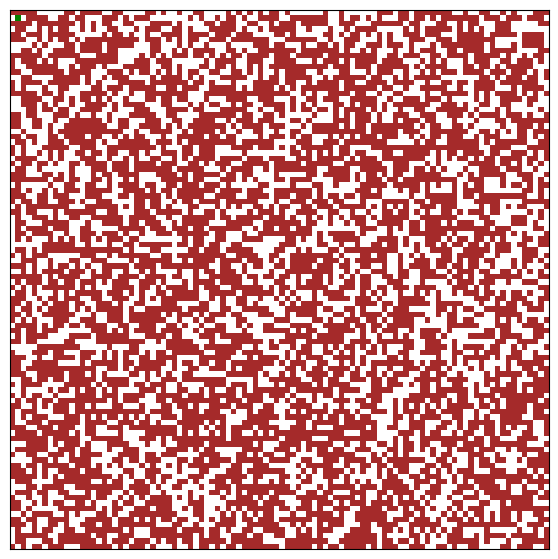

In [1090]:

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])

# Definimos el color para la distinguir agentes, y celdas sucias
#el numero que seteamos anteriormente corresponde al valor del array
#de colores que queremos que se muestre 
cmap = plt.cm.colors.ListedColormap(['white', 'green', 'brown'])

patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=2)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    patch.set_clim(vmin=0, vmax=2)  #establecemos los limites del color

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS)

In [1091]:
anim

C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\3720575041.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


KeyboardInterrupt: 